In [8]:
vp_true, rho_true

(array([1.225, 1.96 , 1.225, 2.695]), array([2., 2., 2., 2.]))

In [1]:
import numpy as np
from disba import PhaseDispersion, depthplot
from dasQt.utils.utils import gen_model1
import matplotlib.pyplot as plt

# Periods must be sorted starting with low periods
fmin, fmax = 3.0, 50.
f = np.linspace(fmin, fmax, 80)
period0 = (1/f)[::-1]
# period0 = np.linspace(1/f.max(), 1/f.min(), 80)

thick_true = np.array([0.01,0.01,0.01,0.01,0.1])
vs_true    = np.array([0.50,0.70,0.50,0.80, 1.1])
thick_true,vp_true,vs_true,rho_true = gen_model1(thick_true,vs_true,area=True)
velocity_model = np.array([
    thick_true.tolist(),
    vp_true.tolist(),
    vs_true.tolist(),
    rho_true.tolist(),
])

pd = PhaseDispersion(*velocity_model)
cpr = pd(period0, mode=0, wave="rayleigh")
# cpl = [pd(t, mode=i, wave="love") for i in range(3)]
period = cpr.period
data = cpr.velocity

plt.plot(1./period, data, label="Rayleigh 0")


    version     :  1.1.0
    author      :  Zhiyu Zhang
    instruction :  JiLin University
    date        :  2024-05-05 20h
    email       :  erbiaoger@gmail.com
    site        :  erbiaoger.site


ModuleNotFoundError: No module named 'dasQt.utils'

In [ ]:
from evodcinv import EarthModel, Layer, Curve

# Initialize model
model = EarthModel()

# for h, v in zip(thick_true, vs_true):
#     model.add(Layer([h*0.8, h*1.2], [v/1.5, v*1.5]))

num = len(thick_true)
for i, (h, v) in enumerate(zip(thick_true, vs_true)):
    if i == num-1:
        model.add(Layer([h, h], [v/1.5, v*1.5]))
        break
    else:
        model.add(Layer([h/3, h/3], [v/1.5, v*1.5]))
        model.add(Layer([h/3, h/3], [v/1.5, v*1.5]))
        model.add(Layer([h/3, h/3], [v/1.5, v*1.5]))
    


# Configure model
model.configure(
    optimizer      = "cpso",       # Evolutionary algorithm,'cmaes','cpso','de','na','pso','vdcma'
    misfit          = "rmse",        # Misfit function type, 'rmse','norm1','norm2'
    optimizer_args = {
                "popsize": 40,      # Population size
                "maxiter": 10000,    # Number of iterations
                "workers": -1,      # Number of cores
                "seed"   : 10,
            },
)
curves = [Curve(period, data, 0, "rayleigh", "phase", weight=1.0, uncertainties=None)]

# Run inversion
res = model.invert(curves)
print(res)

# cpl = [pd(period, mode=i, wave="love") for i in range(3)]


Run 1    |████████████████████| 100% [0:09:20 / 0:00:00] - Misfit: 0.0002


--------------------------------------------------------------------------------
Best model out of 400000 models (1 run)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0033    0.8963    0.5489    1.1553              0.0033    0.5489    0.2000
    0.0033    0.8081    0.4641    1.0678              0.0033    0.4641    0.2539
    0.0033    1.5284    0.6240    1.6531              0.0033    0.6240    0.4000
    0.0033    0.9477    0.4853    1.2040              0.0033    0.4853    0.3223
    0.0033    1.0836    0.6636    1.3253              0.0033    0.6636    0.2000
    0.0033    1.5702    0.6411    1.6791              0.0033    0.6411    0.4000
 

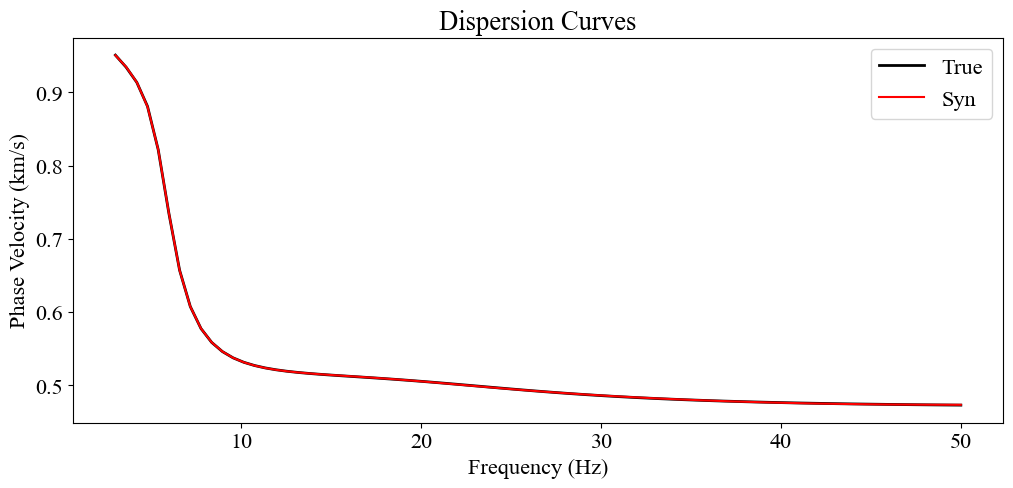

In [120]:
pd = PhaseDispersion(*res.model.T)
cpr = pd(period, mode=0, wave="rayleigh")

import matplotlib.pyplot as plt

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(1, 1, figsize=(12.0, 5))
ax.plot(1/period, data, 'k', label='True', linewidth=2) 
ax.plot(1/cpr.period, cpr.velocity,'r', label='Syn')
ax.legend()

ax.set_title('Dispersion Curves')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.grid(False)

plt.show()

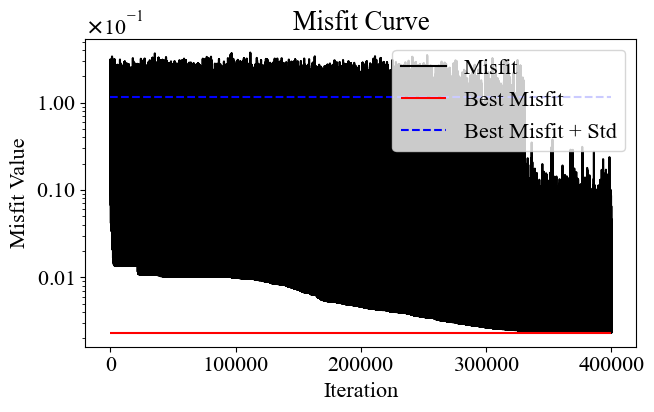

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(16/9*4, 4))

ax.plot(res.misfits, 'k', label='Misfit')
ax.hlines(res.misfit, 0, len(res.misfits), 'r', label='Best Misfit')
ax.hlines(res.misfit*500.1, 0, len(res.misfits), 'b', linestyle='--', label='Best Misfit + Std')

# 设置y轴为log
ax.set_yscale('log')

ax.set_xlabel('Iteration')
ax.set_ylabel('Misfit Value')
ax.set_title('Misfit Curve')

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.legend()

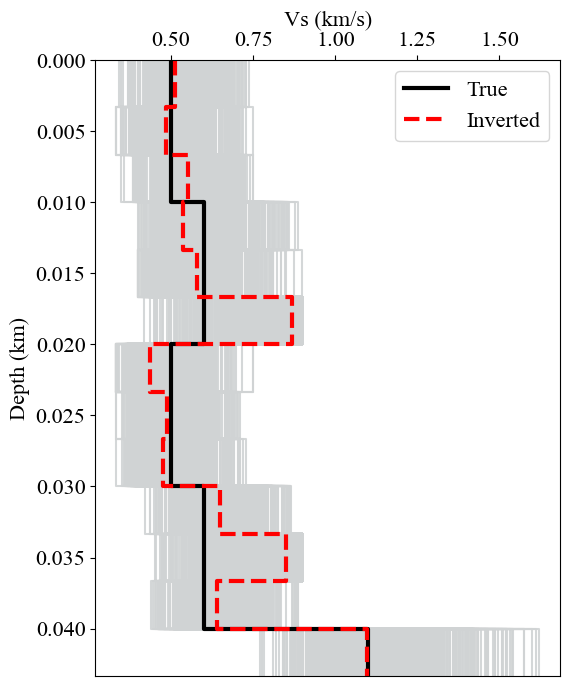

In [113]:
from matplotlib.ticker import ScalarFormatter

def getXinZin(thickness, parameter, ax=None):
    z = np.cumsum(thickness)    # Cumulative sum of thickness
    n = z.size 

    tmp = np.array(thickness)
    tmp[-1] = tmp[:-1].min()
    zmax = tmp.sum()

    # Build layered model
    xin = np.empty(2 * n)
    xin[1::2] = parameter
    xin[2::2] = parameter[1:]
    xin[0] = xin[1]

    zin = np.zeros_like(xin)
    zin[1:-1:2] = z[:-1]
    zin[2::2] = z[:-1]
    zin[-1] = max(z[-1], zmax)
    
    return xin, zin, zmax


fig, ax = plt.subplots(1, 1, figsize=(6.0, 8))

misfit_min = res.misfit
misfit_max = res.misfit*500.1

for i, (model, misfit) in enumerate(zip(res.models, res.misfits)):
    if i % 200 == 0 and i > 4000:
        xin, zin, zmax = getXinZin(model[:, 0], model[:, 2])
        # ax.plot(xin, zin, color=plt.cm.viridis_r((misfit-misfit_min)/(misfit_max-misfit_min)), alpha=0.9)
        ax.plot(xin, zin, color='#D0D3D4', alpha=0.9)


xin, zin, _ = getXinZin(thick_true, vs_true)
ax.plot(xin, zin, 'k', label='True', linewidth=3)


i = 2           #  1: Vp, 2: Vs, 3: density
thickness = res.model[:, 0]
parameter = res.model[:, i]
# thickness = res.models[-10][:, 0]
# parameter = res.models[-10][:, i]
xin, zin, zmax = getXinZin(thickness, parameter)
ax.plot(xin, zin, 'r', linestyle='--', linewidth=3, label='Inverted')


zmax = zmax if zmax < thick_true.sum() else thick_true.sum()
ax.set_ylim(zin.min(),zmax)
ax.xaxis.set_ticks_position('top')  #将X坐标轴移到上面
ax.invert_yaxis()                   #反转Y坐标轴
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')  # 将x轴的标签也移动到顶部
ax.set_xlabel('Vs (km/s)')
ax.set_ylabel('Depth (km)')
# ax.set_title('Inverted Model')
ax.legend()


plt.show()

Plot mean of 40001 models.
Misfit range: 0.0002, 0.0002.


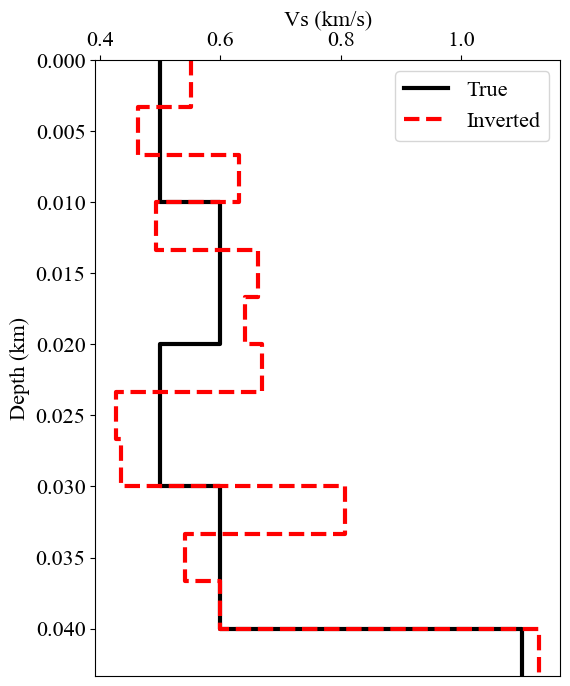

In [122]:

fig, ax = plt.subplots(1, 1, figsize=(6.0, 8))

misfit_min = res.misfit
misfit_max = res.misfit*500.1
# 根据misfits值对模型进行排序
idx = np.argsort(res.misfits)[:]
models = res.models[idx]
misfits = res.misfits[idx]

percent = 10
# 计算需要绘制的模型数量
n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
models = models[:n_select+1]
print('Plot mean of %d models.' %models.shape[0])
print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))

# 计算模型的平均值
model_mean = np.squeeze(np.mean(models, axis=0))


xin, zin, _ = getXinZin(thick_true, vs_true)
ax.plot(xin, zin, 'k', label='True', linewidth=3)


i = 2           #  1: Vp, 2: Vs, 3: density
thickness = model_mean[:, 0]
parameter = model_mean[:, i]
# thickness = res.models[-10][:, 0]
# parameter = res.models[-10][:, i]
xin, zin, zmax = getXinZin(thickness, parameter)
ax.plot(xin, zin, 'r', linestyle='--', linewidth=3, label='Inverted')


zmax = zmax if zmax < thick_true.sum() else thick_true.sum()
ax.set_ylim(zin.min(),zmax)
ax.xaxis.set_ticks_position('top')  #将X坐标轴移到上面
ax.invert_yaxis()                   #反转Y坐标轴
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')  # 将x轴的标签也移动到顶部
ax.set_xlabel('Vs (km/s)')
ax.set_ylabel('Depth (km)')
# ax.set_title('Inverted Model')
ax.legend()


plt.show()

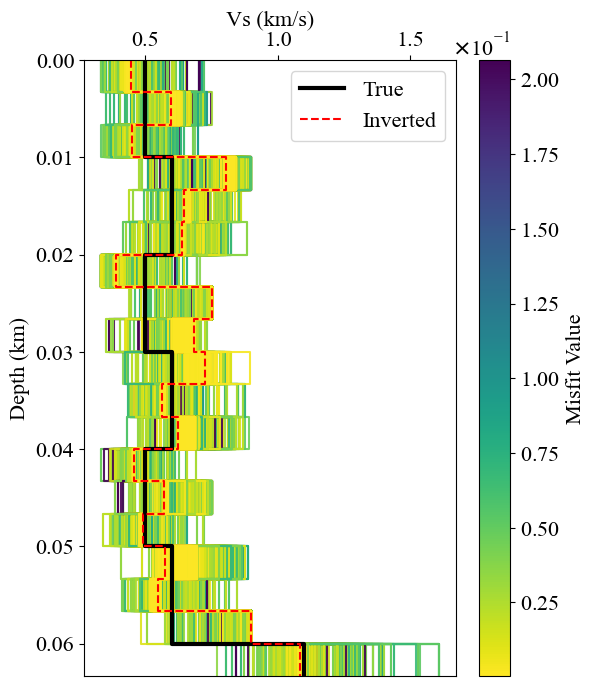

In [63]:

from matplotlib.ticker import ScalarFormatter


def getXinZin(thickness, parameter, ax=None):
    z = np.cumsum(thickness)    # Cumulative sum of thickness
    n = z.size 

    tmp = np.array(thickness)
    tmp[-1] = tmp[:-1].min()
    zmax = tmp.sum()

    # Build layered model
    xin = np.empty(2 * n)
    xin[1::2] = parameter
    xin[2::2] = parameter[1:]
    xin[0] = xin[1]

    zin = np.zeros_like(xin)
    zin[1:-1:2] = z[:-1]
    zin[2::2] = z[:-1]
    zin[-1] = max(z[-1], zmax)
    
    return xin, zin, zmax


fig, ax = plt.subplots(1, 1, figsize=(6.0, 8))

misfit_min = res.misfit
misfit_max = res.misfit*500.1

for i, (model, misfit) in enumerate(zip(res.models, res.misfits)):
    if i % 20 == 0 and i > 400:
        xin, zin, zmax = getXinZin(model[:, 0], model[:, 2])
        # ax.plot(xin, zin, color=plt.cm.viridis_r((misfit-misfit_min)/(misfit_max-misfit_min)), alpha=0.9)
        ax.plot(xin, zin, color=plt.cm.viridis_r((misfit - misfit_min) / (misfit_max - misfit_min)), alpha=0.9)

mappable = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=misfit_min, vmax=misfit_max))
cbar = fig.colorbar(mappable, ax=ax, label='Misfit Value')

# 设置色阶条的标签为科学计数法
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
cbar.formatter = formatter
cbar.update_ticks()


xin, zin, _ = getXinZin(thick_true, vs_true)
ax.plot(xin, zin, 'k', label='True', linewidth=3)


i = 2           #  1: Vp, 2: Vs, 3: density
thickness = res.model[:, 0]
parameter = res.model[:, i]
xin, zin, zmax = getXinZin(thickness, parameter)
ax.plot(xin, zin, 'r', linestyle='--', linewidth=1.5, label='Inverted')


zmax = zmax if zmax < thick_true.sum() else thick_true.sum()
ax.set_ylim(zin.min(),zmax)
ax.xaxis.set_ticks_position('top')  #将X坐标轴移到上面
ax.invert_yaxis()                   #反转Y坐标轴
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')  # 将x轴的标签也移动到顶部
ax.set_xlabel('Vs (km/s)')
ax.set_ylabel('Depth (km)')
# ax.set_title('Inverted Model')
ax.legend()


plt.show()

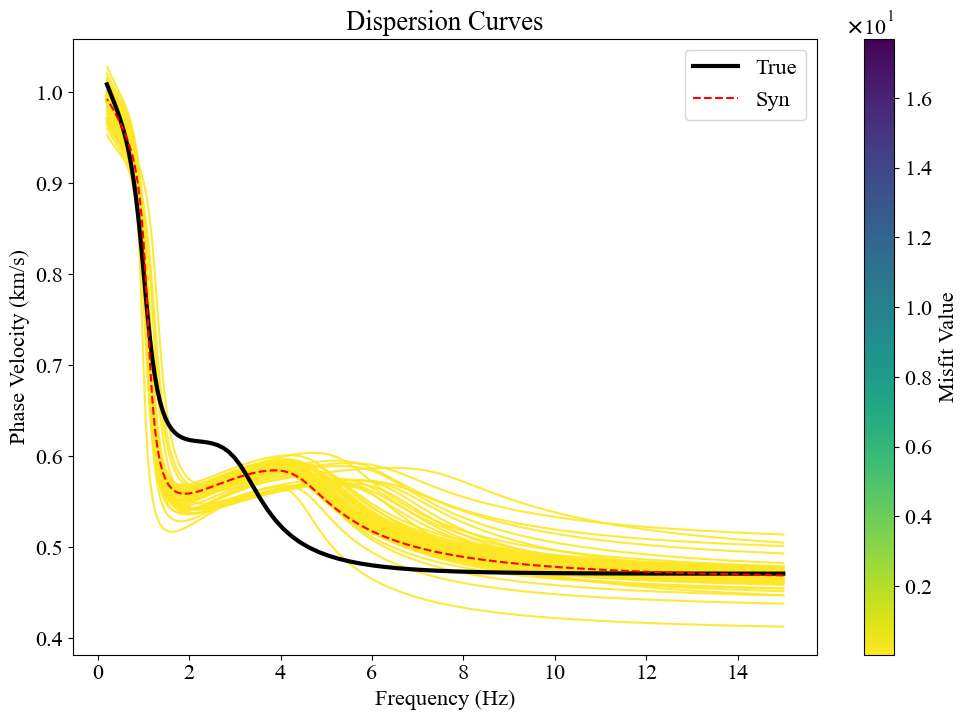

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

misfit_min = res.misfit
misfit_max = res.misfit*500.1

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(12, 8))
for i, (model, misfit) in enumerate(zip(res.models, res.misfits)):
    pd = PhaseDispersion(*model.T)
    try:
        cpr = pd(period, mode=0, wave="rayleigh")
    except:
        continue
    if i % 20 == 0 and i > 400:
        ax.plot(1/cpr.period, cpr.velocity, color=plt.cm.viridis_r((misfit-misfit_min)/(misfit_max-misfit_min)), alpha=0.9)
        # ax.plot(1/cpr.period, cpr.velocity, color=plt.cm.viridis_r(misfit), alpha=0.5)

pd = PhaseDispersion(*res.model.T)
cpr = pd(period, mode=0, wave="rayleigh")
ax.plot(1/period, data, 'k', label='True', linewidth=3)
ax.plot(1/cpr.period, cpr.velocity, color='r', linestyle='--', label='Syn', linewidth=1.5)

# 添加颜色条并使用科学计数法
# mappable = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=misfit_min, vmax=misfit_min*200))
mappable = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=misfit_min, vmax=misfit_max))
cbar = fig.colorbar(mappable, ax=ax, label='Misfit Value')

# 设置色阶条的标签为科学计数法
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
cbar.formatter = formatter
cbar.update_ticks()

ax.set_title('Dispersion Curves')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.grid(False)

ax.legend()
plt.show()


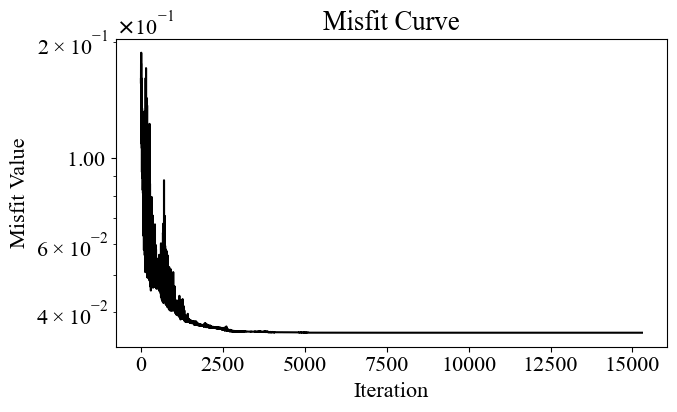

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(16/9*4, 4))

ax.plot(res.misfits, 'k', label='Misfit')

# 设置y轴为log
ax.set_yscale('log')

ax.set_xlabel('Iteration')
ax.set_ylabel('Misfit Value')
ax.set_title('Misfit Curve')

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))